In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import pickle

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [4]:
df_train_dist = pd.read_csv(OUTPUT + '20190611_train_dist_cos.csv')

In [5]:
def type_score(y_val, y_pred):
    return np.log(sum(np.abs(y_val- y_pred)) / len(y_val))

In [6]:
bond_types = df_train_dist['type'].unique()

In [7]:
mols = df_train_dist['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.8)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [8]:
models = []
scores = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : {'l2'},
            'num_leaves' : 31,
            'learning_rate' : 0.1,
            'feature_fraction' : 0.9,
            'bagging_fraction' : 0.8,
            'bagging_freq': 5,
        'verbose_eval':10, 
        'seed':0
    }
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=300,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
    
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
#     y_pred_train = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    score = type_score(y_val, y_pred)
    scores = np.hstack([scores, score])
    models.append(gbm)


[1]	valid_0's l2: 273.661
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 225.74
[3]	valid_0's l2: 186.825
[4]	valid_0's l2: 154.904
[5]	valid_0's l2: 128.991
[6]	valid_0's l2: 107.765
[7]	valid_0's l2: 90.5934
[8]	valid_0's l2: 76.4533
[9]	valid_0's l2: 64.8253
[10]	valid_0's l2: 55.1942
[11]	valid_0's l2: 47.3299
[12]	valid_0's l2: 40.8309
[13]	valid_0's l2: 35.4965
[14]	valid_0's l2: 31.1467
[15]	valid_0's l2: 27.5274
[16]	valid_0's l2: 24.5475
[17]	valid_0's l2: 22.075
[18]	valid_0's l2: 20.0022
[19]	valid_0's l2: 18.2617
[20]	valid_0's l2: 16.8192
[21]	valid_0's l2: 15.5633
[22]	valid_0's l2: 14.5178
[23]	valid_0's l2: 13.6569
[24]	valid_0's l2: 12.8764
[25]	valid_0's l2: 12.233
[26]	valid_0's l2: 11.6848
[27]	valid_0's l2: 11.2025
[28]	valid_0's l2: 10.7677
[29]	valid_0's l2: 10.3923
[30]	valid_0's l2: 10.0643
[31]	valid_0's l2: 9.7559
[32]	valid_0's l2: 9.50271
[33]	valid_0's l2: 9.26367
[34]	valid_0's l2: 9.05887
[35]	valid_0's l2: 8.87877
[36]	v

[299]	valid_0's l2: 3.22863
[300]	valid_0's l2: 3.22494
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 3.22494
[1]	valid_0's l2: 13.3029
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 11.0991
[3]	valid_0's l2: 9.31008
[4]	valid_0's l2: 7.83736
[5]	valid_0's l2: 6.62456
[6]	valid_0's l2: 5.63176
[7]	valid_0's l2: 4.82321
[8]	valid_0's l2: 4.14661
[9]	valid_0's l2: 3.59347
[10]	valid_0's l2: 3.14121
[11]	valid_0's l2: 2.7633
[12]	valid_0's l2: 2.44669
[13]	valid_0's l2: 2.17648
[14]	valid_0's l2: 1.9573
[15]	valid_0's l2: 1.77517
[16]	valid_0's l2: 1.61159
[17]	valid_0's l2: 1.47331
[18]	valid_0's l2: 1.36311
[19]	valid_0's l2: 1.26064
[20]	valid_0's l2: 1.17719
[21]	valid_0's l2: 1.10425
[22]	valid_0's l2: 1.04624
[23]	valid_0's l2: 0.994765
[24]	valid_0's l2: 0.946817
[25]	valid_0's l2: 0.90588
[26]	valid_0's l2: 0.866799
[27]	valid_0's l2: 0.837516
[28]	valid_0's l2: 0.810199
[29]	valid_0's l2: 0.785937
[30]	valid_0's l2: 0.762203


[283]	valid_0's l2: 0.24675
[284]	valid_0's l2: 0.246268
[285]	valid_0's l2: 0.245928
[286]	valid_0's l2: 0.245383
[287]	valid_0's l2: 0.245039
[288]	valid_0's l2: 0.244721
[289]	valid_0's l2: 0.244125
[290]	valid_0's l2: 0.243718
[291]	valid_0's l2: 0.243193
[292]	valid_0's l2: 0.242488
[293]	valid_0's l2: 0.242171
[294]	valid_0's l2: 0.241727
[295]	valid_0's l2: 0.241359
[296]	valid_0's l2: 0.240998
[297]	valid_0's l2: 0.240716
[298]	valid_0's l2: 0.240467
[299]	valid_0's l2: 0.239974
[300]	valid_0's l2: 0.239777
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 0.239777
[1]	valid_0's l2: 97.1641
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 79.4557
[3]	valid_0's l2: 65.1096
[4]	valid_0's l2: 53.4235
[5]	valid_0's l2: 43.8781
[6]	valid_0's l2: 36.1843
[7]	valid_0's l2: 29.8972
[8]	valid_0's l2: 24.7274
[9]	valid_0's l2: 20.5316
[10]	valid_0's l2: 17.1173
[11]	valid_0's l2: 14.3306
[12]	valid_0's l2: 12.057
[13]	valid_0's l2: 10.1942

[285]	valid_0's l2: 0.474064
[286]	valid_0's l2: 0.472924
[287]	valid_0's l2: 0.472343
[288]	valid_0's l2: 0.471554
[289]	valid_0's l2: 0.470901
[290]	valid_0's l2: 0.470739
[291]	valid_0's l2: 0.470364
[292]	valid_0's l2: 0.470133
[293]	valid_0's l2: 0.469867
[294]	valid_0's l2: 0.469782
[295]	valid_0's l2: 0.469158
[296]	valid_0's l2: 0.46838
[297]	valid_0's l2: 0.468128
[298]	valid_0's l2: 0.467495
[299]	valid_0's l2: 0.466361
[300]	valid_0's l2: 0.465571
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 0.465571
[1]	valid_0's l2: 11.4368
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 9.7252
[3]	valid_0's l2: 8.30595
[4]	valid_0's l2: 7.15702
[5]	valid_0's l2: 6.17008
[6]	valid_0's l2: 5.37034
[7]	valid_0's l2: 4.69654
[8]	valid_0's l2: 4.14836
[9]	valid_0's l2: 3.68447
[10]	valid_0's l2: 3.27206
[11]	valid_0's l2: 2.9259
[12]	valid_0's l2: 2.62185
[13]	valid_0's l2: 2.38541
[14]	valid_0's l2: 2.18667
[15]	valid_0's l2: 2.0124
[16]	

[286]	valid_0's l2: 0.251341
[287]	valid_0's l2: 0.25107
[288]	valid_0's l2: 0.250725
[289]	valid_0's l2: 0.250205
[290]	valid_0's l2: 0.249705
[291]	valid_0's l2: 0.249523
[292]	valid_0's l2: 0.249273
[293]	valid_0's l2: 0.249008
[294]	valid_0's l2: 0.248757
[295]	valid_0's l2: 0.248319
[296]	valid_0's l2: 0.247996
[297]	valid_0's l2: 0.247683
[298]	valid_0's l2: 0.247471
[299]	valid_0's l2: 0.24703
[300]	valid_0's l2: 0.246812
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 0.246812
[1]	valid_0's l2: 17.4624
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 15.0115
[3]	valid_0's l2: 13.0526
[4]	valid_0's l2: 11.4112
[5]	valid_0's l2: 10.0345
[6]	valid_0's l2: 8.93097
[7]	valid_0's l2: 7.96591
[8]	valid_0's l2: 7.19094
[9]	valid_0's l2: 6.52521
[10]	valid_0's l2: 5.97285
[11]	valid_0's l2: 5.51048
[12]	valid_0's l2: 5.10869
[13]	valid_0's l2: 4.75104
[14]	valid_0's l2: 4.46177
[15]	valid_0's l2: 4.22076
[16]	valid_0's l2: 3.99174
[17]	

[281]	valid_0's l2: 0.962207
[282]	valid_0's l2: 0.96039
[283]	valid_0's l2: 0.959767
[284]	valid_0's l2: 0.958984
[285]	valid_0's l2: 0.957907
[286]	valid_0's l2: 0.955698
[287]	valid_0's l2: 0.954757
[288]	valid_0's l2: 0.953952
[289]	valid_0's l2: 0.952223
[290]	valid_0's l2: 0.951005
[291]	valid_0's l2: 0.94982
[292]	valid_0's l2: 0.948418
[293]	valid_0's l2: 0.947743
[294]	valid_0's l2: 0.946318
[295]	valid_0's l2: 0.944308
[296]	valid_0's l2: 0.942678
[297]	valid_0's l2: 0.941554
[298]	valid_0's l2: 0.940771
[299]	valid_0's l2: 0.940004
[300]	valid_0's l2: 0.938583
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 0.938583
[1]	valid_0's l2: 12.5255
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 11.5235
[3]	valid_0's l2: 10.6637
[4]	valid_0's l2: 9.91463
[5]	valid_0's l2: 9.31251
[6]	valid_0's l2: 8.76849
[7]	valid_0's l2: 8.3229
[8]	valid_0's l2: 7.94764
[9]	valid_0's l2: 7.58476
[10]	valid_0's l2: 7.28233
[11]	valid_0's l2: 7.00

[277]	valid_0's l2: 2.17289
[278]	valid_0's l2: 2.17149
[279]	valid_0's l2: 2.16996
[280]	valid_0's l2: 2.16822
[281]	valid_0's l2: 2.1661
[282]	valid_0's l2: 2.16461
[283]	valid_0's l2: 2.16285
[284]	valid_0's l2: 2.16187
[285]	valid_0's l2: 2.15881
[286]	valid_0's l2: 2.15495
[287]	valid_0's l2: 2.15186
[288]	valid_0's l2: 2.15002
[289]	valid_0's l2: 2.14688
[290]	valid_0's l2: 2.14569
[291]	valid_0's l2: 2.1434
[292]	valid_0's l2: 2.14159
[293]	valid_0's l2: 2.13853
[294]	valid_0's l2: 2.13541
[295]	valid_0's l2: 2.13162
[296]	valid_0's l2: 2.12825
[297]	valid_0's l2: 2.12434
[298]	valid_0's l2: 2.12048
[299]	valid_0's l2: 2.11776
[300]	valid_0's l2: 2.11518
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 2.11518
[1]	valid_0's l2: 8.95757
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 8.62748
[3]	valid_0's l2: 8.32076
[4]	valid_0's l2: 8.06076
[5]	valid_0's l2: 7.82067
[6]	valid_0's l2: 7.63887
[7]	valid_0's l2: 7.4712
[8]	valid_0

[270]	valid_0's l2: 3.2925
[271]	valid_0's l2: 3.28944
[272]	valid_0's l2: 3.28742
[273]	valid_0's l2: 3.28489
[274]	valid_0's l2: 3.28264
[275]	valid_0's l2: 3.27672
[276]	valid_0's l2: 3.27418
[277]	valid_0's l2: 3.27206
[278]	valid_0's l2: 3.26993
[279]	valid_0's l2: 3.26791
[280]	valid_0's l2: 3.26596
[281]	valid_0's l2: 3.26298
[282]	valid_0's l2: 3.25966
[283]	valid_0's l2: 3.25534
[284]	valid_0's l2: 3.25167
[285]	valid_0's l2: 3.24938
[286]	valid_0's l2: 3.24663
[287]	valid_0's l2: 3.24253
[288]	valid_0's l2: 3.23873
[289]	valid_0's l2: 3.23611
[290]	valid_0's l2: 3.2342
[291]	valid_0's l2: 3.23066
[292]	valid_0's l2: 3.22714
[293]	valid_0's l2: 3.22465
[294]	valid_0's l2: 3.2207
[295]	valid_0's l2: 3.21915
[296]	valid_0's l2: 3.21673
[297]	valid_0's l2: 3.2131
[298]	valid_0's l2: 3.20906
[299]	valid_0's l2: 3.20668
[300]	valid_0's l2: 3.20383
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 3.20383
[1]	valid_0's l2: 1.53306
Training until validation scores d

In [9]:
print('type score:', scores)
print('total score:', scores.mean())

type score: [ 0.25243139 -1.14232183 -0.783953   -1.12205245 -0.43376459  0.02100559
  0.30430121 -1.29425978]
total score: -0.5248266828541803


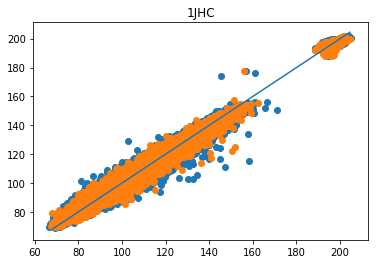

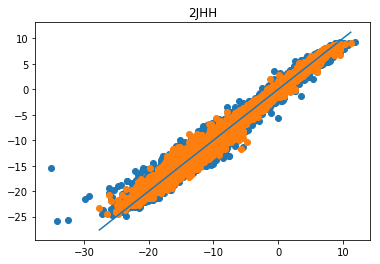

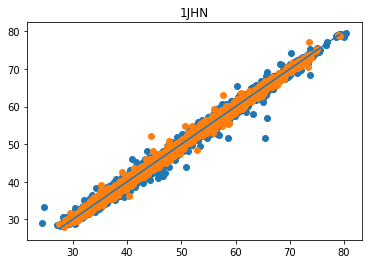

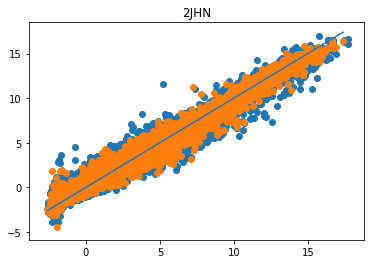

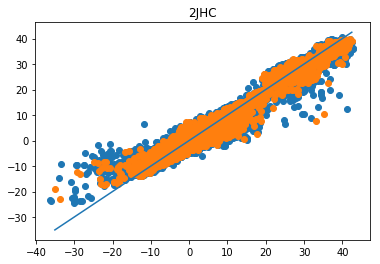

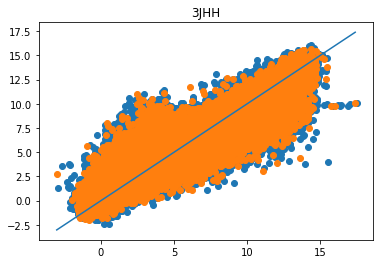

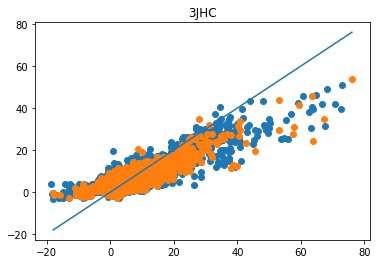

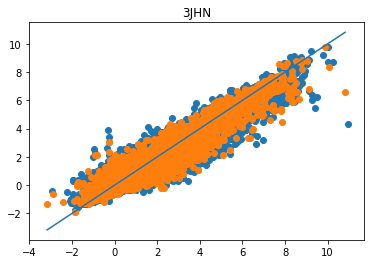

In [10]:
for i, b in enumerate(bond_types):
    df = df_train_dist.query('type == "{}"'.format(b))
    y = df['scalar_coupling_constant'].values
    X = df[df.columns[6:]].values

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    model = models[i]
    
    y_pred = model.predict(X_val, num_iteration=gbm.best_iteration)
    y_pred_train = model.predict(X_train, num_iteration=gbm.best_iteration)
    plt.scatter(y_train, y_pred_train)
    plt.scatter(y_val, y_pred)
    plt.title('{}'.format(b))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
    plt.show()

In [11]:
with open(OUTPUT + '20190613_champs_models_lgb.pickle', 'wb') as f:
    pickle.dump(models, f)